# Versión con Ajuste Fino (Fine-Tuning) para el modelo multi-salida

Esta versión del código implementa el ajuste fino descongelando las últimas capas del modelo base EfficientNetB0 para mejorar la adaptación a tu conjunto de datos.

1. Entrenamiento:
    - Se utiliza EfficientNetB0 como modelo base, con ajuste fino descongelando las últimas 30 capas.
    - Se emplean generadores de datos con aumentos para el conjunto de entrenamiento.
    - El modelo tiene tres salidas para las tareas de partes, daños y sugerencias.
    - Se entrena inicialmente con la base congelada y luego se realiza fine-tuning con tasa de aprendizaje menor.
    - Se usan callbacks de EarlyStopping y ModelCheckpoint para evitar sobreajuste y guardar el mejor modelo.

2. Evaluación:
    - Se evalúa el modelo en el conjunto de prueba, mostrando pérdidas y accuracies por tarea.
    - Se generan reportes de clasificación detallados con precisión, recall y f1-score para cada clase.
    - Los resultados muestran buen desempeño en "sugerencias" (F1 ~0.9), desempeño moderado a bajo en "daños" y bajo en "partes", con muchas clases sin detección efectiva.

3. Predicción:
    - Se implementan funciones para predecir nuevas imágenes y mostrar resultados con las top 3 clases por categoría.
    - Se visualizan las predicciones junto con la imagen original.

!pip install tensorflow

In [14]:
# Importar librerías necesarias
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [15]:
# =============================================
# CONFIGURACIÓN
# =============================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 30  # Entrenamiento inicial con base congelada
EPOCHS_FINE_TUNE = 30  # Entrenamiento con ajuste fino
LEARNING_RATE_INITIAL = 5e-5  # Ajuste de tasa de aprendizaje inicial
LEARNING_RATE_FINE_TUNE = 5e-6  # Ajuste de tasa de aprendizaje para fine-tuning
BASE_MODEL = 'EfficientNetB0'

In [16]:
# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

In [17]:
# =============================================
# CARGA DE DATOS
# =============================================
def load_and_prepare_data(split_dir):
    """Carga imágenes y etiquetas para un conjunto (train/val/test)"""
    df = pd.read_csv(f'{split_dir}/{split_dir.split("/")[-1]}_set.csv', sep='|')
    # Convertir strings de listas a listas reales
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    return df

# Cargar todos los conjuntos
train_df = load_and_prepare_data('data/fotos_siniestros/train')
val_df = load_and_prepare_data('data/fotos_siniestros/val')
test_df = load_and_prepare_data('data/fotos_siniestros/test')

In [18]:
# =============================================
# PREPARACIÓN DE ETIQUETAS
# =============================================
mlb_partes = MultiLabelBinarizer()
mlb_dannos = MultiLabelBinarizer()
mlb_sugerencias = MultiLabelBinarizer()

y_train_partes = mlb_partes.fit_transform(train_df['partes'])
y_train_dannos = mlb_dannos.fit_transform(train_df['dannos'])
y_train_sugerencias = mlb_sugerencias.fit_transform(train_df['sugerencias'])

y_val_partes = mlb_partes.transform(val_df['partes'])
y_val_dannos = mlb_dannos.transform(val_df['dannos'])
y_val_sugerencias = mlb_sugerencias.transform(val_df['sugerencias'])

# Guardar MultiLabelBinarizer objects para uso posterior
import pickle
with open("mlb_partes.pkl", "wb") as f:
    pickle.dump(mlb_partes, f)
with open("mlb_dannos.pkl", "wb") as f:
    pickle.dump(mlb_dannos, f)
with open("mlb_sugerencias.pkl", "wb") as f:
    pickle.dump(mlb_sugerencias, f)
print("MultiLabelBinarizer objects saved.")

MultiLabelBinarizer objects saved.


In [19]:
# =============================================
# GENERADOR DE DATOS
# =============================================
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None):
        self.df = df
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.empty((len(batch_df), *self.img_size, 3))
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            y_partes.append(row['partes'])
            y_dannos.append(row['dannos'])
            y_sugerencias.append(row['sugerencias'])
        
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

IMG_DIR = '../data/fotos_siniestros/'

train_generator = MultiLabelDataGenerator(
    train_df, 
    IMG_DIR, 
    mlb_partes, 
    mlb_dannos, 
    mlb_sugerencias,
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augmentation=train_datagen
)

val_generator = MultiLabelDataGenerator(
    val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

test_generator = MultiLabelDataGenerator(
    test_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

In [ ]:
# =============================================
# CONSTRUCCIÓN DEL MODELO CON AJUSTE FINO Y MEJORAS
# =============================================
# 1600 fotos
# Last Execution 7:40:54 PM
# Execution Time 24m 21.9s
# Overhead Time 104ms
# Render Times
# VS Code Builtin Notebook Output Renderer 117ms

# 1700 fotos
# Last Execution 12:15:38 PM
# Execution Time 21m 21.5s
# Overhead Time 2m 55.8s
# Render Times
# VS Code Builtin Notebook Output Renderer 69ms

# 1700 fotos
# Last Execution 9:32:52 AM
# Execution Time 37m 36.8s
# Overhead Time 3m 59.1s
# Render Times
# VS Code Builtin Notebook Output Renderer 180ms

def build_multi_output_model_fine_tuning(input_shape, num_partes, num_dannos, num_sugerencias, base_model_name='EfficientNetB0'):
    if base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(
            include_top=False, 
            weights='imagenet', 
            input_shape=input_shape
        )
    elif base_model_name == 'ResNet50':
        base_model = applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Modelo base no soportado: {base_model_name}")

    # Congelar todas las capas inicialmente
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Reducido dropout para menos regularización

    output_partes = layers.Dense(num_partes, activation='sigmoid', name='partes')(x)
    output_dannos = layers.Dense(num_dannos, activation='sigmoid', name='dannos')(x)
    output_sugerencias = layers.Dense(num_sugerencias, activation='sigmoid', name='sugerencias')(x)

    model = models.Model(
        inputs=inputs,
        outputs=[output_partes, output_dannos, output_sugerencias]
    )

    return model

# Construir modelo
model = build_multi_output_model_fine_tuning(
    input_shape=(*IMG_SIZE, 3),
    num_partes=len(mlb_partes.classes_),
    num_dannos=len(mlb_dannos.classes_),
    num_sugerencias=len(mlb_sugerencias.classes_),
    base_model_name=BASE_MODEL
)

# Compilar para entrenamiento inicial
model.compile(
    optimizer=Adam(learning_rate=5e-5),  # tasa de aprendizaje inicial ajustada
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_fine_tuning.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento inicial con base congelada
history_initial = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_INITIAL,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Descongelar últimas capas para ajuste fino
base_model = model.layers[1]  # Asumiendo que la segunda capa es el modelo base
base_model.trainable = True

# Congelar todas las capas excepto las últimas 30 (más capas descongeladas)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar con tasa de aprendizaje menor
model.compile(
    optimizer=Adam(learning_rate=5e-6),  # tasa de aprendizaje para fine-tuning ajustada
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Entrenamiento con ajuste fino
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Guardar modelo final
model.save('final_model_fine_tuned_v2.keras')

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.1963 - dannos_loss: 0.7355 - loss: 2.0662 - partes_accuracy: 0.0196 - partes_loss: 0.6838 - sugerencias_accuracy: 0.6301 - sugerencias_loss: 0.6422
Epoch 1: val_loss improved from inf to 1.71947, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - dannos_accuracy: 0.1973 - dannos_loss: 0.7339 - loss: 2.0627 - partes_accuracy: 0.0197 - partes_loss: 0.6828 - sugerencias_accuracy: 0.6326 - sugerencias_loss: 0.6414 - val_dannos_accuracy: 0.3071 - val_dannos_loss: 0.5904 - val_loss: 1.7195 - val_partes_accuracy: 0.0118 - val_partes_loss: 0.5748 - val_sugerencias_accuracy: 0.8189 - val_sugerencias_loss: 0.5540
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.3133 - dannos_loss: 0.5562 - loss: 1.6235 - partes_accuracy: 0.0151 - partes_loss: 0.5354 - sugerencias_accuracy: 0.8087 - sugerencias_loss: 0.5609
Epoch 2: val_loss improved from 1.71947 to 1.47641, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - dannos_accuracy: 0.3134 - dannos_loss: 0.5557 - loss: 1.6220 - partes_accuracy: 0.0153 - partes_loss: 0.5345 - sugerencias_accuracy: 0.8089 - sugerencias_loss: 0.5604 - val_dannos_accuracy: 0.3701 - val_dannos_loss: 0.5224 - val_loss: 1.4764 - val_partes_accuracy: 0.0236 - val_partes_loss: 0.4573 - val_sugerencias_accuracy: 0.8661 - val_sugerencias_loss: 0.4965
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.3802 - dannos_loss: 0.5042 - loss: 1.4173 - partes_accuracy: 0.0241 - partes_loss: 0.4116 - sugerencias_accuracy: 0.8494 - sugerencias_loss: 0.5001
Epoch 3: val_loss improved from 1.47641 to 1.31319, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.3798 - dannos_loss: 0.5041 - loss: 1.4164 - partes_accuracy: 0.0244 - partes_loss: 0.4109 - sugerencias_accuracy: 0.8493 - sugerencias_loss: 0.4999 - val_dannos_accuracy: 0.4055 - val_dannos_loss: 0.4965 - val_loss: 1.3132 - val_partes_accuracy: 0.0236 - val_partes_loss: 0.3663 - val_sugerencias_accuracy: 0.8661 - val_sugerencias_loss: 0.4503
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4067 - dannos_loss: 0.4834 - loss: 1.2779 - partes_accuracy: 0.0616 - partes_loss: 0.3211 - sugerencias_accuracy: 0.8523 - sugerencias_loss: 0.4742
Epoch 4: val_loss improved from 1.31319 to 1.21062, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.4064 - dannos_loss: 0.4833 - loss: 1.2772 - partes_accuracy: 0.0615 - partes_loss: 0.3207 - sugerencias_accuracy: 0.8525 - sugerencias_loss: 0.4740 - val_dannos_accuracy: 0.4488 - val_dannos_loss: 0.4816 - val_loss: 1.2106 - val_partes_accuracy: 0.0512 - val_partes_loss: 0.3085 - val_sugerencias_accuracy: 0.8780 - val_sugerencias_loss: 0.4207
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4110 - dannos_loss: 0.4769 - loss: 1.1885 - partes_accuracy: 0.0844 - partes_loss: 0.2730 - sugerencias_accuracy: 0.8521 - sugerencias_loss: 0.4392
Epoch 5: val_loss improved from 1.21062 to 1.14452, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dannos_accuracy: 0.4111 - dannos_loss: 0.4769 - loss: 1.1880 - partes_accuracy: 0.0844 - partes_loss: 0.2728 - sugerencias_accuracy: 0.8523 - sugerencias_loss: 0.4389 - val_dannos_accuracy: 0.4764 - val_dannos_loss: 0.4703 - val_loss: 1.1445 - val_partes_accuracy: 0.1614 - val_partes_loss: 0.2731 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.4014
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4384 - dannos_loss: 0.4473 - loss: 1.1063 - partes_accuracy: 0.1058 - partes_loss: 0.2384 - sugerencias_accuracy: 0.8610 - sugerencias_loss: 0.3895
Epoch 6: val_loss improved from 1.14452 to 1.09443, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.4380 - dannos_loss: 0.4477 - loss: 1.1065 - partes_accuracy: 0.1064 - partes_loss: 0.2384 - sugerencias_accuracy: 0.8612 - sugerencias_loss: 0.3899 - val_dannos_accuracy: 0.5079 - val_dannos_loss: 0.4597 - val_loss: 1.0944 - val_partes_accuracy: 0.1929 - val_partes_loss: 0.2500 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3849
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4282 - dannos_loss: 0.4617 - loss: 1.0950 - partes_accuracy: 0.1501 - partes_loss: 0.2277 - sugerencias_accuracy: 0.8518 - sugerencias_loss: 0.4087
Epoch 7: val_loss improved from 1.09443 to 1.06266, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - dannos_accuracy: 0.4282 - dannos_loss: 0.4618 - loss: 1.0947 - partes_accuracy: 0.1505 - partes_loss: 0.2276 - sugerencias_accuracy: 0.8519 - sugerencias_loss: 0.4086 - val_dannos_accuracy: 0.5157 - val_dannos_loss: 0.4522 - val_loss: 1.0627 - val_partes_accuracy: 0.2205 - val_partes_loss: 0.2356 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.3750
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4841 - dannos_loss: 0.4457 - loss: 1.0651 - partes_accuracy: 0.1436 - partes_loss: 0.2242 - sugerencias_accuracy: 0.8495 - sugerencias_loss: 0.3874
Epoch 8: val_loss improved from 1.06266 to 1.03772, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.4838 - dannos_loss: 0.4458 - loss: 1.0646 - partes_accuracy: 0.1441 - partes_loss: 0.2240 - sugerencias_accuracy: 0.8499 - sugerencias_loss: 0.3872 - val_dannos_accuracy: 0.5276 - val_dannos_loss: 0.4443 - val_loss: 1.0377 - val_partes_accuracy: 0.2402 - val_partes_loss: 0.2259 - val_sugerencias_accuracy: 0.8780 - val_sugerencias_loss: 0.3678
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4638 - dannos_loss: 0.4357 - loss: 1.0193 - partes_accuracy: 0.1724 - partes_loss: 0.2087 - sugerencias_accuracy: 0.8588 - sugerencias_loss: 0.3639
Epoch 9: val_loss improved from 1.03772 to 1.01722, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - dannos_accuracy: 0.4640 - dannos_loss: 0.4358 - loss: 1.0196 - partes_accuracy: 0.1724 - partes_loss: 0.2087 - sugerencias_accuracy: 0.8586 - sugerencias_loss: 0.3642 - val_dannos_accuracy: 0.5394 - val_dannos_loss: 0.4378 - val_loss: 1.0172 - val_partes_accuracy: 0.2480 - val_partes_loss: 0.2185 - val_sugerencias_accuracy: 0.8780 - val_sugerencias_loss: 0.3612
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5010 - dannos_loss: 0.4374 - loss: 1.0283 - partes_accuracy: 0.1737 - partes_loss: 0.2060 - sugerencias_accuracy: 0.8634 - sugerencias_loss: 0.3841
Epoch 10: val_loss improved from 1.01722 to 0.99988, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5005 - dannos_loss: 0.4373 - loss: 1.0278 - partes_accuracy: 0.1744 - partes_loss: 0.2059 - sugerencias_accuracy: 0.8634 - sugerencias_loss: 0.3835 - val_dannos_accuracy: 0.5512 - val_dannos_loss: 0.4314 - val_loss: 0.9999 - val_partes_accuracy: 0.2795 - val_partes_loss: 0.2125 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.3562
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5039 - dannos_loss: 0.4338 - loss: 0.9795 - partes_accuracy: 0.1980 - partes_loss: 0.2021 - sugerencias_accuracy: 0.8581 - sugerencias_loss: 0.3532
Epoch 11: val_loss improved from 0.99988 to 0.98561, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5036 - dannos_loss: 0.4339 - loss: 0.9798 - partes_accuracy: 0.1983 - partes_loss: 0.2022 - sugerencias_accuracy: 0.8581 - sugerencias_loss: 0.3533 - val_dannos_accuracy: 0.5591 - val_dannos_loss: 0.4268 - val_loss: 0.9856 - val_partes_accuracy: 0.2953 - val_partes_loss: 0.2076 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.3514
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5044 - dannos_loss: 0.4207 - loss: 0.9653 - partes_accuracy: 0.2293 - partes_loss: 0.1972 - sugerencias_accuracy: 0.8672 - sugerencias_loss: 0.3472
Epoch 12: val_loss improved from 0.98561 to 0.97106, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dannos_accuracy: 0.5044 - dannos_loss: 0.4208 - loss: 0.9654 - partes_accuracy: 0.2292 - partes_loss: 0.1972 - sugerencias_accuracy: 0.8672 - sugerencias_loss: 0.3472 - val_dannos_accuracy: 0.5630 - val_dannos_loss: 0.4207 - val_loss: 0.9711 - val_partes_accuracy: 0.2992 - val_partes_loss: 0.2036 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3470
Epoch 13/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4997 - dannos_loss: 0.4407 - loss: 0.9876 - partes_accuracy: 0.2242 - partes_loss: 0.2029 - sugerencias_accuracy: 0.8539 - sugerencias_loss: 0.3653
Epoch 13: val_loss improved from 0.97106 to 0.95990, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.4996 - dannos_loss: 0.4405 - loss: 0.9871 - partes_accuracy: 0.2245 - partes_loss: 0.2027 - sugerencias_accuracy: 0.8539 - sugerencias_loss: 0.3651 - val_dannos_accuracy: 0.5551 - val_dannos_loss: 0.4163 - val_loss: 0.9599 - val_partes_accuracy: 0.3189 - val_partes_loss: 0.2004 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3434
Epoch 14/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.4707 - dannos_loss: 0.4234 - loss: 0.9797 - partes_accuracy: 0.2236 - partes_loss: 0.1919 - sugerencias_accuracy: 0.8707 - sugerencias_loss: 0.3471
Epoch 14: val_loss improved from 0.95990 to 0.95080, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - dannos_accuracy: 0.4714 - dannos_loss: 0.4232 - loss: 0.9792 - partes_accuracy: 0.2239 - partes_loss: 0.1919 - sugerencias_accuracy: 0.8707 - sugerencias_loss: 0.3470 - val_dannos_accuracy: 0.5669 - val_dannos_loss: 0.4126 - val_loss: 0.9508 - val_partes_accuracy: 0.3189 - val_partes_loss: 0.1973 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3412
Epoch 15/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5222 - dannos_loss: 0.4111 - loss: 0.9548 - partes_accuracy: 0.2081 - partes_loss: 0.1961 - sugerencias_accuracy: 0.8551 - sugerencias_loss: 0.3443
Epoch 15: val_loss improved from 0.95080 to 0.94193, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - dannos_accuracy: 0.5227 - dannos_loss: 0.4110 - loss: 0.9542 - partes_accuracy: 0.2087 - partes_loss: 0.1959 - sugerencias_accuracy: 0.8555 - sugerencias_loss: 0.3439 - val_dannos_accuracy: 0.5787 - val_dannos_loss: 0.4095 - val_loss: 0.9419 - val_partes_accuracy: 0.3307 - val_partes_loss: 0.1948 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3378
Epoch 16/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5335 - dannos_loss: 0.4087 - loss: 0.9286 - partes_accuracy: 0.2224 - partes_loss: 0.1907 - sugerencias_accuracy: 0.8709 - sugerencias_loss: 0.3300
Epoch 16: val_loss improved from 0.94193 to 0.93507, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5330 - dannos_loss: 0.4088 - loss: 0.9287 - partes_accuracy: 0.2229 - partes_loss: 0.1907 - sugerencias_accuracy: 0.8706 - sugerencias_loss: 0.3301 - val_dannos_accuracy: 0.5748 - val_dannos_loss: 0.4063 - val_loss: 0.9351 - val_partes_accuracy: 0.3346 - val_partes_loss: 0.1927 - val_sugerencias_accuracy: 0.8780 - val_sugerencias_loss: 0.3363
Epoch 17/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5240 - dannos_loss: 0.4110 - loss: 0.9268 - partes_accuracy: 0.2482 - partes_loss: 0.1844 - sugerencias_accuracy: 0.8540 - sugerencias_loss: 0.3321
Epoch 17: val_loss improved from 0.93507 to 0.92955, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5245 - dannos_loss: 0.4108 - loss: 0.9269 - partes_accuracy: 0.2484 - partes_loss: 0.1844 - sugerencias_accuracy: 0.8542 - sugerencias_loss: 0.3324 - val_dannos_accuracy: 0.5866 - val_dannos_loss: 0.4036 - val_loss: 0.9296 - val_partes_accuracy: 0.3386 - val_partes_loss: 0.1908 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.3353
Epoch 18/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5688 - dannos_loss: 0.3962 - loss: 0.8840 - partes_accuracy: 0.2689 - partes_loss: 0.1820 - sugerencias_accuracy: 0.8911 - sugerencias_loss: 0.3040
Epoch 18: val_loss improved from 0.92955 to 0.92234, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5685 - dannos_loss: 0.3960 - loss: 0.8842 - partes_accuracy: 0.2688 - partes_loss: 0.1820 - sugerencias_accuracy: 0.8907 - sugerencias_loss: 0.3042 - val_dannos_accuracy: 0.5748 - val_dannos_loss: 0.3999 - val_loss: 0.9223 - val_partes_accuracy: 0.3465 - val_partes_loss: 0.1883 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.3342
Epoch 19/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5620 - dannos_loss: 0.3841 - loss: 0.8888 - partes_accuracy: 0.2731 - partes_loss: 0.1808 - sugerencias_accuracy: 0.8652 - sugerencias_loss: 0.3247
Epoch 19: val_loss improved from 0.92234 to 0.91740, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - dannos_accuracy: 0.5621 - dannos_loss: 0.3845 - loss: 0.8890 - partes_accuracy: 0.2731 - partes_loss: 0.1809 - sugerencias_accuracy: 0.8650 - sugerencias_loss: 0.3245 - val_dannos_accuracy: 0.5709 - val_dannos_loss: 0.3988 - val_loss: 0.9174 - val_partes_accuracy: 0.3622 - val_partes_loss: 0.1864 - val_sugerencias_accuracy: 0.8780 - val_sugerencias_loss: 0.3323
Epoch 20/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5656 - dannos_loss: 0.3904 - loss: 0.8749 - partes_accuracy: 0.2970 - partes_loss: 0.1829 - sugerencias_accuracy: 0.8578 - sugerencias_loss: 0.3033
Epoch 20: val_loss improved from 0.91740 to 0.91528, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - dannos_accuracy: 0.5654 - dannos_loss: 0.3905 - loss: 0.8752 - partes_accuracy: 0.2966 - partes_loss: 0.1828 - sugerencias_accuracy: 0.8580 - sugerencias_loss: 0.3035 - val_dannos_accuracy: 0.5827 - val_dannos_loss: 0.3975 - val_loss: 0.9153 - val_partes_accuracy: 0.3701 - val_partes_loss: 0.1852 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.3327
Epoch 21/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5559 - dannos_loss: 0.4012 - loss: 0.8853 - partes_accuracy: 0.2781 - partes_loss: 0.1792 - sugerencias_accuracy: 0.8669 - sugerencias_loss: 0.3252
Epoch 21: val_loss improved from 0.91528 to 0.91069, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5561 - dannos_loss: 0.4011 - loss: 0.8855 - partes_accuracy: 0.2780 - partes_loss: 0.1793 - sugerencias_accuracy: 0.8666 - sugerencias_loss: 0.3253 - val_dannos_accuracy: 0.5984 - val_dannos_loss: 0.3952 - val_loss: 0.9107 - val_partes_accuracy: 0.3740 - val_partes_loss: 0.1838 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.3318
Epoch 22/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5781 - dannos_loss: 0.3724 - loss: 0.8733 - partes_accuracy: 0.2780 - partes_loss: 0.1776 - sugerencias_accuracy: 0.8713 - sugerencias_loss: 0.3175
Epoch 22: val_loss improved from 0.91069 to 0.90494, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - dannos_accuracy: 0.5775 - dannos_loss: 0.3727 - loss: 0.8734 - partes_accuracy: 0.2780 - partes_loss: 0.1776 - sugerencias_accuracy: 0.8711 - sugerencias_loss: 0.3173 - val_dannos_accuracy: 0.5866 - val_dannos_loss: 0.3918 - val_loss: 0.9049 - val_partes_accuracy: 0.3740 - val_partes_loss: 0.1821 - val_sugerencias_accuracy: 0.8780 - val_sugerencias_loss: 0.3312
Epoch 23/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5345 - dannos_loss: 0.3863 - loss: 0.8512 - partes_accuracy: 0.3067 - partes_loss: 0.1725 - sugerencias_accuracy: 0.8807 - sugerencias_loss: 0.2925
Epoch 23: val_loss improved from 0.90494 to 0.89913, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5352 - dannos_loss: 0.3863 - loss: 0.8519 - partes_accuracy: 0.3061 - partes_loss: 0.1726 - sugerencias_accuracy: 0.8803 - sugerencias_loss: 0.2930 - val_dannos_accuracy: 0.6142 - val_dannos_loss: 0.3901 - val_loss: 0.8991 - val_partes_accuracy: 0.3701 - val_partes_loss: 0.1803 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3289
Epoch 24/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5658 - dannos_loss: 0.3696 - loss: 0.8246 - partes_accuracy: 0.2904 - partes_loss: 0.1708 - sugerencias_accuracy: 0.8861 - sugerencias_loss: 0.2755
Epoch 24: val_loss improved from 0.89913 to 0.89437, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5657 - dannos_loss: 0.3699 - loss: 0.8256 - partes_accuracy: 0.2902 - partes_loss: 0.1709 - sugerencias_accuracy: 0.8858 - sugerencias_loss: 0.2760 - val_dannos_accuracy: 0.6181 - val_dannos_loss: 0.3889 - val_loss: 0.8944 - val_partes_accuracy: 0.3740 - val_partes_loss: 0.1787 - val_sugerencias_accuracy: 0.8819 - val_sugerencias_loss: 0.3270
Epoch 25/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5524 - dannos_loss: 0.3828 - loss: 0.8840 - partes_accuracy: 0.2703 - partes_loss: 0.1785 - sugerencias_accuracy: 0.8566 - sugerencias_loss: 0.3228
Epoch 25: val_loss improved from 0.89437 to 0.89080, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - dannos_accuracy: 0.5524 - dannos_loss: 0.3827 - loss: 0.8835 - partes_accuracy: 0.2706 - partes_loss: 0.1784 - sugerencias_accuracy: 0.8570 - sugerencias_loss: 0.3225 - val_dannos_accuracy: 0.6181 - val_dannos_loss: 0.3870 - val_loss: 0.8908 - val_partes_accuracy: 0.3740 - val_partes_loss: 0.1775 - val_sugerencias_accuracy: 0.8898 - val_sugerencias_loss: 0.3265
Epoch 26/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5490 - dannos_loss: 0.3816 - loss: 0.8227 - partes_accuracy: 0.2973 - partes_loss: 0.1716 - sugerencias_accuracy: 0.8653 - sugerencias_loss: 0.2672
Epoch 26: val_loss improved from 0.89080 to 0.88750, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dannos_accuracy: 0.5490 - dannos_loss: 0.3816 - loss: 0.8234 - partes_accuracy: 0.2971 - partes_loss: 0.1716 - sugerencias_accuracy: 0.8653 - sugerencias_loss: 0.2679 - val_dannos_accuracy: 0.6142 - val_dannos_loss: 0.3857 - val_loss: 0.8875 - val_partes_accuracy: 0.3701 - val_partes_loss: 0.1759 - val_sugerencias_accuracy: 0.8898 - val_sugerencias_loss: 0.3261
Epoch 27/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5626 - dannos_loss: 0.3768 - loss: 0.8366 - partes_accuracy: 0.3264 - partes_loss: 0.1679 - sugerencias_accuracy: 0.8806 - sugerencias_loss: 0.2967
Epoch 27: val_loss improved from 0.88750 to 0.88676, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - dannos_accuracy: 0.5628 - dannos_loss: 0.3768 - loss: 0.8370 - partes_accuracy: 0.3260 - partes_loss: 0.1680 - sugerencias_accuracy: 0.8801 - sugerencias_loss: 0.2970 - val_dannos_accuracy: 0.6063 - val_dannos_loss: 0.3841 - val_loss: 0.8868 - val_partes_accuracy: 0.3740 - val_partes_loss: 0.1748 - val_sugerencias_accuracy: 0.8780 - val_sugerencias_loss: 0.3281
Epoch 28/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5637 - dannos_loss: 0.3701 - loss: 0.8357 - partes_accuracy: 0.2838 - partes_loss: 0.1710 - sugerencias_accuracy: 0.8413 - sugerencias_loss: 0.2933
Epoch 28: val_loss improved from 0.88676 to 0.88042, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.5640 - dannos_loss: 0.3702 - loss: 0.8358 - partes_accuracy: 0.2843 - partes_loss: 0.1711 - sugerencias_accuracy: 0.8417 - sugerencias_loss: 0.2932 - val_dannos_accuracy: 0.6063 - val_dannos_loss: 0.3833 - val_loss: 0.8804 - val_partes_accuracy: 0.3780 - val_partes_loss: 0.1735 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3238
Epoch 29/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5669 - dannos_loss: 0.3789 - loss: 0.8604 - partes_accuracy: 0.2904 - partes_loss: 0.1707 - sugerencias_accuracy: 0.8682 - sugerencias_loss: 0.3115
Epoch 29: val_loss improved from 0.88042 to 0.87542, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - dannos_accuracy: 0.5669 - dannos_loss: 0.3787 - loss: 0.8596 - partes_accuracy: 0.2910 - partes_loss: 0.1707 - sugerencias_accuracy: 0.8683 - sugerencias_loss: 0.3110 - val_dannos_accuracy: 0.6339 - val_dannos_loss: 0.3813 - val_loss: 0.8754 - val_partes_accuracy: 0.3780 - val_partes_loss: 0.1723 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3219
Epoch 30/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.6232 - dannos_loss: 0.3637 - loss: 0.8192 - partes_accuracy: 0.3056 - partes_loss: 0.1720 - sugerencias_accuracy: 0.8651 - sugerencias_loss: 0.2827
Epoch 30: val_loss improved from 0.87542 to 0.87375, saving model to best_model_fine_tuning.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - dannos_accuracy: 0.6225 - dannos_loss: 0.3638 - loss: 0.8194 - partes_accuracy: 0.3056 - partes_loss: 0.1719 - sugerencias_accuracy: 0.8651 - sugerencias_loss: 0.2828 - val_dannos_accuracy: 0.6299 - val_dannos_loss: 0.3813 - val_loss: 0.8738 - val_partes_accuracy: 0.3819 - val_partes_loss: 0.1713 - val_sugerencias_accuracy: 0.8858 - val_sugerencias_loss: 0.3212
Restoring model weights from the end of the best epoch: 30.
Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.5190 - dannos_loss: 0.5097 - loss: 1.2642 - partes_accuracy: 0.2847 - partes_loss: 0.2876 - sugerencias_accuracy: 0.7441 - sugerencias_loss: 0.4866
Epoch 1: val_loss did not improve from 0.87375
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - dannos_accuracy: 0.5187 - dannos_loss: 0.5095 - loss: 1.2639 - partes_accuracy: 0.2848 - partes_loss: 0.2876 - sugerencias_accuracy: 0.7440 - sugerencias_loss: 0.4861 - val_dannos_accuracy: 0.5827 - val_dannos_loss: 0.3958 - val_

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_3[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ partes (Dense)      │ (None, 29)        │     14,877 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dannos (Dense)      │ (None, 6)         │      3,078 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sugerencias (Dense) │ (None, 2)         │      1,026 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,066,452 (34.59 MB)

 Trainable params: 2,171,013 (8.28 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

 Optimizer params: 4,342,028 (16.56 MB)

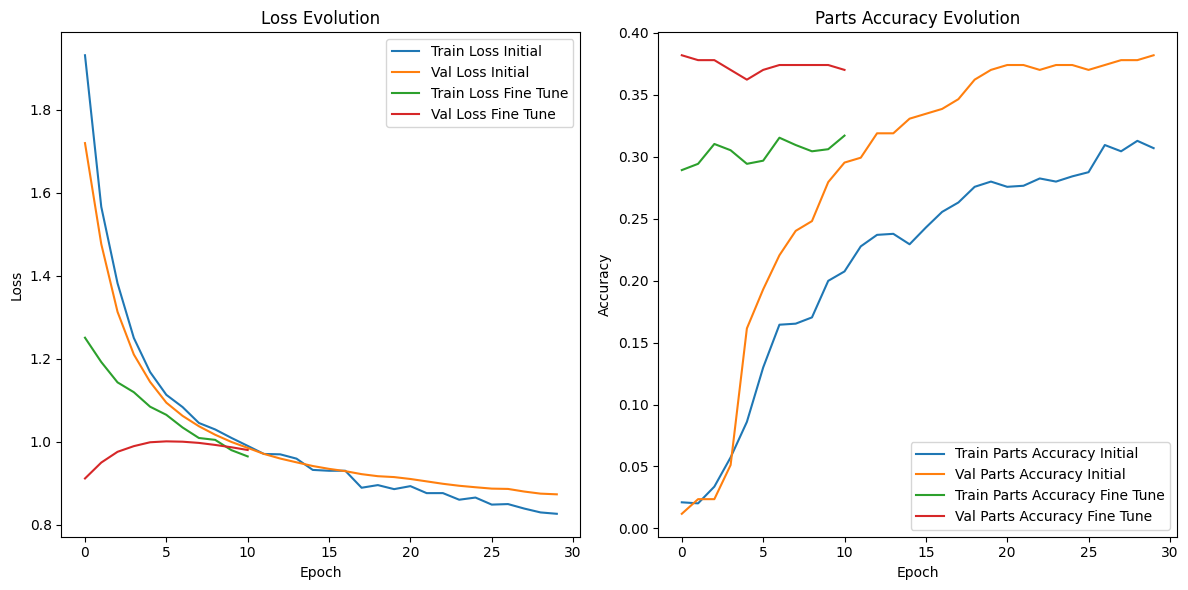

In [11]:
# Función para visualizar el historial de entrenamiento
def plot_training_history(history1, history2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='Train Loss Initial')
    plt.plot(history1.history['val_loss'], label='Val Loss Initial')
    plt.plot(history2.history['loss'], label='Train Loss Fine Tune')
    plt.plot(history2.history['val_loss'], label='Val Loss Fine Tune')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['partes_accuracy'], label='Train Parts Accuracy Initial')
    plt.plot(history1.history['val_partes_accuracy'], label='Val Parts Accuracy Initial')
    plt.plot(history2.history['partes_accuracy'], label='Train Parts Accuracy Fine Tune')
    plt.plot(history2.history['val_partes_accuracy'], label='Val Parts Accuracy Fine Tune')
    plt.title('Parts Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizar resultados
plot_training_history(history_initial, history_fine_tune)

In [11]:
# =============================================
# EVALUACIÓN
# =============================================
def evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias):
    """Evalúa el modelo en el conjunto de prueba y muestra métricas"""
    # Evaluación general
    results = model.evaluate(test_generator, verbose=1)
    print(f"Pérdida total: {results[0]}")
    print(f"Pérdida partes: {results[1]} - Accuracy partes: {results[4]}")
    print(f"Pérdida daños: {results[2]} - Accuracy daños: {results[5]}")
    print(f"Pérdida sugerencias: {results[3]} - Accuracy sugerencias: {results[6]}")

    # Predicciones
    print("\nGenerando predicciones...")
    predictions = model.predict(test_generator, verbose=1)
    y_pred_partes = predictions[0] > 0.5
    y_pred_dannos = predictions[1] > 0.5
    y_pred_sugerencias = predictions[2] > 0.5

    # Obtener etiquetas verdaderas
    y_true_partes = test_generator.mlb_partes.transform(test_df['partes'])
    y_true_dannos = test_generator.mlb_dannos.transform(test_df['dannos'])
    y_true_sugerencias = test_generator.mlb_sugerencias.transform(test_df['sugerencias'])

    # Convertir IDs de clases a nombres
    def get_class_names(classes, label_dict):
        return [str(label_dict.get(int(cls), f"Clase_{cls}")) for cls in classes]

    partes_names = get_class_names(mlb_partes.classes_, label_to_cls_piezas)
    dannos_names = get_class_names(mlb_dannos.classes_, label_to_cls_danos)
    sugerencias_names = get_class_names(mlb_sugerencias.classes_, label_to_cls_sugerencias)

    # Reportes de clasificación
    print("\nReporte para Partes:")
    print(classification_report(
        y_true_partes,
        y_pred_partes,
        target_names=partes_names,
        zero_division=0
    ))

    print("\nReporte para Daños:")
    print(classification_report(
        y_true_dannos,
        y_pred_dannos,
        target_names=dannos_names,
        zero_division=0
    ))

    print("\nReporte para Sugerencias:")
    print(classification_report(
        y_true_sugerencias,
        y_pred_sugerencias,
        target_names=sugerencias_names,
        zero_division=0
    ))

    return {
        'results': results,
        'predictions': {
            'partes': y_pred_partes,
            'dannos': y_pred_dannos,
            'sugerencias': y_pred_sugerencias
        },
        'true_labels': {
            'partes': y_true_partes,
            'dannos': y_true_dannos,
            'sugerencias': y_true_sugerencias
        }
    }

# Realizar evaluación
evaluation_results = evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias)

NameError: name 'test_generator' is not defined

Análisis Detallado de los Resultados de Evaluación

1. Métricas Generales del Modelo
    - Pérdida Total (Loss): 0.8867
        - Valor relativamente alto, sugiere margen de mejora.
    - Accuracy por Tarea:
        - Partes: 57.69% (Bajo)
        - Daños: 35.38% (Muy bajo)
        - Sugerencias: 85.38% (Bueno)

2. Rendimiento por Categoría

    - a) Partes del Vehículo
        - Problemas Graves:
            - Precision/Recall/Fl-score mayormente 0: El modelo no identifica correctamente la mayoría de las partes (ej: Capó, Faros, Puertas).
            - Excepciones:
                - Parabrisas delantero: F1=0.82 (Buen rendimiento).
                - Parachoques delantero: F1=0.70.
                - Rueda: Precision perfecta (1.00) pero bajo recall (0.37).

    - b) Tipos de Daños
        - Mejor Rendimiento:
            - Abolladura: F1=0.64.
            - Rayón: F1=0.62.
            - Rotura: F1=0.62.
        - Problemas:
            - Desprendimiento: F1=0.00 (No detectado).
            - Fractura: Bajo recall (0.07).

    - c) Sugerencias
        - Excelente Rendimiento:
            - Reparar: F1=0.95.
            - Reemplazar: F1=0.79.

3. Posibles Causas de los Problemas
    1. Desequilibrio de Datos:
        - Algunas clases (ej: "Rejilla, parrilla") tienen muy pocos ejemplos (support=3).
    2. Complejidad del Modelo:
        - Puede ser insuficiente para tareas multiclase complejas (especialmente en "Partes").
    3. Umbral de Clasificación:
        - El umbral > 0.5 puede no ser óptimo para todas las clases.

Sugerencias para mejorar el modelo:

- Abordar el desequilibrio de clases con técnicas como ponderación de clases o muestreo.
- Ajustar umbrales de clasificación para cada clase en lugar de usar 0.5 fijo.
- Incrementar la cantidad y diversidad de datos, especialmente para clases con bajo soporte.
- Experimentar con arquitecturas más complejas o modelos especializados por tarea.
- Aplicar técnicas adicionales de regularización y ajuste de hiperparámetros.

Para ajustar parámetros y generar visualizaciones que ayuden a mejorar el modelo, algunas pruebas y análisis:

1. Curvas de Precisión-Recall por Clase:
    - Generar curvas de precisión y recall para cada clase, lo que permite ajustar umbrales de decisión específicos para mejorar el equilibrio entre precisión y recall.

2. Matrices de Confusión por Tarea:
    - Visualizar matrices de confusión para las tareas de partes, daños y sugerencias, para identificar patrones de error y clases confundidas.

3. Análisis de Distribución de Clases:
    - Visualizar la distribución de muestras por clase para detectar desequilibrios y decidir estrategias de muestreo o ponderación.

4. Ajuste de Umbrales de Clasificación:
    - Probar diferentes umbrales de corte para las predicciones sigmoid para cada clase, optimizando métricas como F1-score.

5. Evaluación con Métricas Macro y Micro:
    - Comparar métricas macro y micro para entender el impacto de clases minoritarias.

6. Visualización de Ejemplos Mal Clasificados:
    - Mostrar imágenes con predicciones erróneas para análisis cualitativo.

7. Pruebas de Regularización y Arquitectura:
    - Experimentar con diferentes tasas de dropout, número de capas descongeladas y arquitecturas base.

---

In [ ]:
# Cargando el modelo
if __name__ == "__main__":
    import pickle

    # Cargar modelo
    model_path = "final_model_fine_tuned_v2.keras"  # Cambiar si se usa otro archivo
    model = load_model(model_path)

    # Cargar MultiLabelBinarizer guardados (adaptar rutas)
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

2025-05-14 10:44:48.071403: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Modelo cargado desde final_model_fine_tuned_v2.keras


In [1]:
# Cell 1: Imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

In [2]:
# Cell 2: Function to plot confusion matrices
def plot_confusion_matrices(y_true, y_pred, class_names, task_name, max_classes=10):
    """
    Plots confusion matrices for multilabel classification task.

    Args:
        y_true (np.array): True binary labels, shape (num_samples, num_classes)
        y_pred (np.array): Predicted binary labels, shape (num_samples, num_classes)
        class_names (list): List of class names corresponding to columns in y_true/y_pred
        task_name (str): Name of the task (for plot titles)
        max_classes (int): Maximum number of classes to plot (to avoid too many plots)
    """
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    num_classes = len(class_names)
    classes_to_plot = min(num_classes, max_classes)

    plt.figure(figsize=(15, 4 * classes_to_plot))
    for i in range(classes_to_plot):
        cm = mcm[i]
        tn, fp, fn, tp = cm.ravel()
        cm_matrix = np.array([[tp, fn],
                              [fp, tn]])
        ax = plt.subplot(classes_to_plot, 1, i + 1)
        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Actual Positive', 'Actual Negative'],
                    yticklabels=['Predicted Positive', 'Predicted Negative'])
        ax.set_title(f'{task_name} - Confusion Matrix for Class: {class_names[i]}')
        ax.set_ylabel('Predicted label')
        ax.set_xlabel('True label')
    plt.tight_layout()
    plt.show()

In [3]:
# Cell 3: Function to generate confusion matrices by task
def generate_confusion_matrices_by_task(evaluation_results, mlb_partes, mlb_dannos, mlb_sugerencias,
                                        label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias):
    """
    Generate and plot confusion matrices for parts, damages, and suggestions tasks.

    Args:
        evaluation_results (dict): Dictionary containing 'true_labels' and 'predictions' for each task.
        mlb_partes, mlb_dannos, mlb_sugerencias: MultiLabelBinarizer objects for each task.
        label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias: Dicts mapping class indices to names.
    """
    # Extract true and predicted labels
    y_true_partes = evaluation_results['true_labels']['partes']
    y_pred_partes = evaluation_results['predictions']['partes']

    y_true_dannos = evaluation_results['true_labels']['dannos']
    y_pred_dannos = evaluation_results['predictions']['dannos']

    y_true_sugerencias = evaluation_results['true_labels']['sugerencias']
    y_pred_sugerencias = evaluation_results['predictions']['sugerencias']

    # Map class indices to names
    partes_names = [label_to_cls_piezas.get(int(cls), f"Clase_{cls}") for cls in mlb_partes.classes_]
    dannos_names = [label_to_cls_danos.get(int(cls), f"Clase_{cls}") for cls in mlb_dannos.classes_]
    sugerencias_names = [label_to_cls_sugerencias.get(int(cls), f"Clase_{cls}") for cls in mlb_sugerencias.classes_]

    # Plot confusion matrices for each task
    print("Plotting confusion matrices for Partes...")
    plot_confusion_matrices(y_true_partes, y_pred_partes, partes_names, "Partes")

    print("Plotting confusion matrices for Daños...")
    plot_confusion_matrices(y_true_dannos, y_pred_dannos, dannos_names, "Daños")

    print("Plotting confusion matrices for Sugerencias...")
    plot_confusion_matrices(y_true_sugerencias, y_pred_sugerencias, sugerencias_names, "Sugerencias")

In [ ]:
generate_confusion_matrices_by_task(
    evaluation_results,
    mlb_partes, mlb_dannos, mlb_sugerencias,
    label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias
)

In [ ]:
# Cell 1: Imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Cell 2: Function to plot confusion matrices
def plot_confusion_matrices(y_true, y_pred, class_names, task_name, max_classes=10):
    """
    Plots confusion matrices for multilabel classification task.

    Args:
        y_true (np.array): True binary labels, shape (num_samples, num_classes)
        y_pred (np.array): Predicted binary labels, shape (num_samples, num_classes)
        class_names (list): List of class names corresponding to columns in y_true/y_pred
        task_name (str): Name of the task (for plot titles)
        max_classes (int): Maximum number of classes to plot (to avoid too many plots)
    """
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    num_classes = len(class_names)
    classes_to_plot = min(num_classes, max_classes)

    plt.figure(figsize=(15, 4 * classes_to_plot))
    for i in range(classes_to_plot):
        cm = mcm[i]
        tn, fp, fn, tp = cm.ravel()
        cm_matrix = np.array([[tp, fn],
                              [fp, tn]])
        ax = plt.subplot(classes_to_plot, 1, i + 1)
        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Actual Positive', 'Actual Negative'],
                    yticklabels=['Predicted Positive', 'Predicted Negative'])
        ax.set_title(f'{task_name} - Confusion Matrix for Class: {class_names[i]}')
        ax.set_ylabel('Predicted label')
        ax.set_xlabel('True label')
    plt.tight_layout()
    plt.show()

# Cell 3: Function to generate confusion matrices by task
def generate_confusion_matrices_by_task(evaluation_results, mlb_partes, mlb_dannos, mlb_sugerencias,
                                        label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias):
    """
    Generate and plot confusion matrices for parts, damages, and suggestions tasks.

    Args:
        evaluation_results (dict): Dictionary containing 'true_labels' and 'predictions' for each task.
        mlb_partes, mlb_dannos, mlb_sugerencias: MultiLabelBinarizer objects for each task.
        label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias: Dicts mapping class indices to names.
    """
    # Extract true and predicted labels
    y_true_partes = evaluation_results['true_labels']['partes']
    y_pred_partes = evaluation_results['predictions']['partes']

    y_true_dannos = evaluation_results['true_labels']['dannos']
    y_pred_dannos = evaluation_results['predictions']['dannos']

    y_true_sugerencias = evaluation_results['true_labels']['sugerencias']
    y_pred_sugerencias = evaluation_results['predictions']['sugerencias']

    # Map class indices to names
    partes_names = [label_to_cls_piezas.get(int(cls), f"Clase_{cls}") for cls in mlb_partes.classes_]
    dannos_names = [label_to_cls_danos.get(int(cls), f"Clase_{cls}") for cls in mlb_dannos.classes_]
    sugerencias_names = [label_to_cls_sugerencias.get(int(cls), f"Clase_{cls}") for cls in mlb_sugerencias.classes_]

    # Plot confusion matrices for each task
    print("Plotting confusion matrices for Partes...")
    plot_confusion_matrices(y_true_partes, y_pred_partes, partes_names, "Partes")

    print("Plotting confusion matrices for Daños...")
    plot_confusion_matrices(y_true_dannos, y_pred_dannos, dannos_names, "Daños")

    print("Plotting confusion matrices for Sugerencias...")
    plot_confusion_matrices(y_true_sugerencias, y_pred_sugerencias, sugerencias_names, "Sugerencias") 

generate_confusion_matrices_by_task(
    evaluation_results,
    mlb_partes, mlb_dannos, mlb_sugerencias,
    label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias
)       

---

In [13]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES
# =============================================
def predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """Realiza predicciones para una nueva imagen"""
    # Cargar y preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Hacer predicción
    predictions = model.predict(img_array)

    # Procesar resultados
    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    # Obtener las clases con mayor probabilidad (top 3 para cada categoría)
    top_partes = sorted(zip(mlb_partes.classes_, partes_probs), key=lambda x: x[1], reverse=True)[:3]
    top_dannos = sorted(zip(mlb_dannos.classes_, dannos_probs), key=lambda x: x[1], reverse=True)[:3]
    top_sugerencias = sorted(zip(mlb_sugerencias.classes_, sugerencias_probs), key=lambda x: x[1], reverse=True)[:3]

    # Convertir IDs a nombres
    def get_names(items, label_dict):
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in items]

    partes_nombres = get_names(top_partes, label_to_cls_piezas)
    dannos_nombres = get_names(top_dannos, label_to_cls_danos)
    sugerencias_nombres = get_names(top_sugerencias, label_to_cls_sugerencias)

    return {
        'partes': partes_nombres,
        'dannos': dannos_nombres,
        'sugerencias': sugerencias_nombres
    }

def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

In [19]:
# Ejemplo de uso
image_path = "../data/predecir/golpe_02.jpg"  # Asegúrate que esta ruta es correcta
prediction = predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)
print_predictions(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

Predicciones para la imagen:

Partes:
- Parachoques trasero: 53.84% de probabilidad
- Parachoques delantero: 45.08% de probabilidad
- Guardabarros trasero izquierdo: 28.96% de probabilidad

Dannos:
- Abolladura: 68.61% de probabilidad
- Rotura: 44.25% de probabilidad
- Deformación: 29.16% de probabilidad

Sugerencias:
- Reparar: 90.86% de probabilidad
- Reemplazar: 61.90% de probabilidad


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step

Predicciones para la imagen:

Partes:
- Rueda: 34.73% de probabilidad
- Guardabarros delantero izquierdo: 27.82% de probabilidad
- Parachoques delantero: 24.46% de probabilidad

Dannos:
- Abolladura: 54.11% de probabilidad
- Rotura: 42.21% de probabilidad
- Desprendimiento: 17.35% de probabilidad

Sugerencias:
- Reparar: 73.02% de probabilidad
- Reemplazar: 43.34% de probabilidad

In [26]:
# Ruta a la imagen de prueba
# image_path = "../data/predecir/golpe_01.jpg"
# image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
# image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


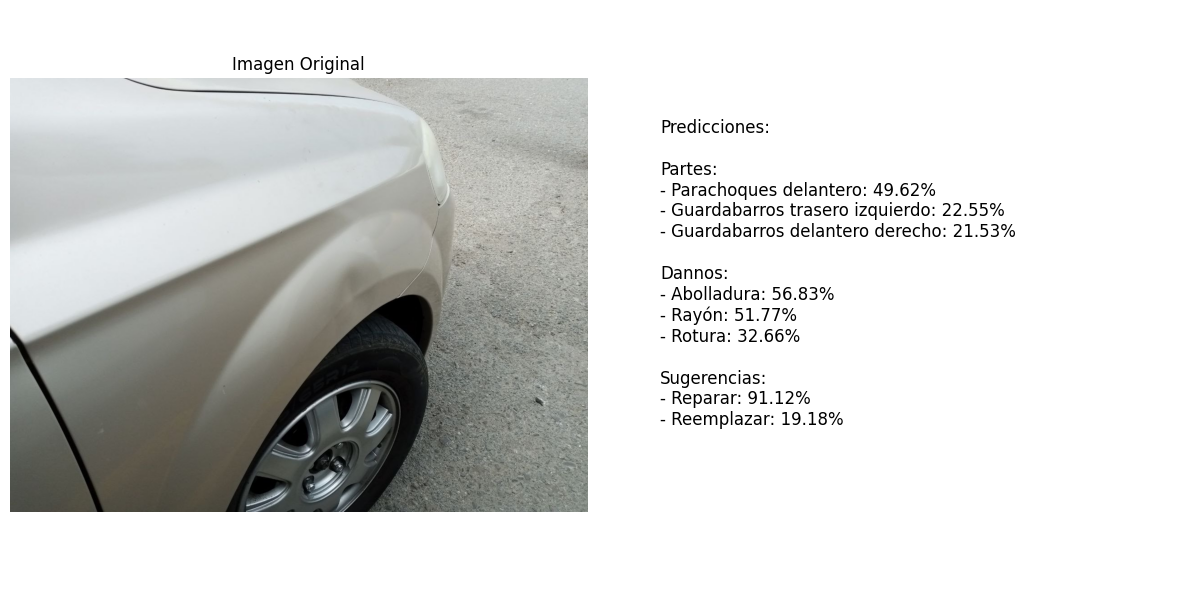

In [27]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Visualización y predicción ejemplo
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

---

In [17]:
# Guardar resultados
def save_evaluation_results(results, filename='evaluation_results_fine_tuning.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning.json


In [18]:
# =============================================
# GUARDAR RESULTADOS
# =============================================
def save_evaluation_results(results, filename='evaluation_results_fine_tuning_v2.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning_v2.json


---
cargar el modelo ya entrenado

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import applications
import os

# Diccionarios de mapeo (debe adaptarse si se usan otros)
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

def load_model(model_path):
    """
    Carga un modelo guardado en formato .keras o .h5 sin necesidad de reentrenar.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

def preprocess_image(image_path, img_size=(224, 224)):
    """
    Carga y preprocesa una imagen para la predicción.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_path, model, mlb_partes, mlb_danos, mlb_sugerencias):
    """
    Realiza predicción usando el modelo cargado para una imagen dada.
    """
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    def get_top_predictions(classes, probs, label_dict, top_n=3):
        top_items = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]

    partes_pred = get_top_predictions(mlb_partes.classes_, partes_probs, label_to_cls_piezas)
    dannos_pred = get_top_predictions(mlb_danos.classes_, dannos_probs, label_to_cls_danos)
    sugerencias_pred = get_top_predictions(mlb_sugerencias.classes_, sugerencias_probs, label_to_cls_sugerencias)

    return {
        'partes': partes_pred,
        'dannos': dannos_pred,
        'sugerencias': sugerencias_pred
    }

2025-05-14 10:37:29.174164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 10:37:29.189255: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 10:37:29.297527: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 10:37:29.378760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747233449.486254   29862 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747233449.52

In [26]:
# Ejemplo de uso (adaptar mlb_* según su entorno)
if __name__ == "__main__":
    import pickle

    # Cargar modelo
    model_path = "final_model_fine_tuned_v2.keras"  # Cambiar si se usa otro archivo
    model = load_model(model_path)

    # Cargar MultiLabelBinarizer guardados (adaptar rutas)
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

Modelo cargado desde final_model_fine_tuned_v2.keras


In [27]:
# Ruta imagen para predecir
image_path = "../data/predecir/golpe_01.jpg"

In [28]:
# Realizar predicción
prediction = predict(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)

print("Predicciones:")
for category, preds in prediction.items():
    print(f"\n{category.capitalize()}:")
    for name, prob in preds:
        print(f"- {name}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
Predicciones:

Partes:
- Rueda: 34.73%
- Guardabarros delantero izquierdo: 27.82%
- Parachoques delantero: 24.46%

Dannos:
- Abolladura: 54.11%
- Rotura: 42.21%
- Desprendimiento: 17.35%

Sugerencias:
- Reparar: 73.02%
- Reemplazar: 43.34%


---

Prediciendo, usando custom thresholds

In [28]:
import os
import json
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import applications

In [29]:
def load_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

In [30]:
def load_mlb_objects():
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)
    return mlb_partes, mlb_dannos, mlb_sugerencias

In [31]:
def load_thresholds(thresholds_path):
    if not os.path.exists(thresholds_path):
        raise FileNotFoundError(f"El archivo de umbrales no existe: {thresholds_path}")
    with open(thresholds_path, 'r') as f:
        thresholds = json.load(f)
    return thresholds

In [32]:
def preprocess_image(image_path, img_size=(224, 224)):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [33]:
def predict_with_thresholds(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds_partes, img_size=(224, 224)):
    img_array = preprocess_image(image_path, img_size)
    predictions = model.predict(img_array)

    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    # Aplicar umbrales personalizados para partes
    partes_pred = []
    for i, cls in enumerate(mlb_partes.classes_):
        cls_name = str(cls)
        threshold = thresholds_partes.get(cls_name, 0.5)  # usar 0.5 si no está definido
        partes_pred.append((cls_name, partes_probs[i], partes_probs[i] >= threshold))

    # Para daños y sugerencias se usa umbral fijo 0.5 (puede extenderse si se desea)
    dannos_pred = [(str(cls), dannos_probs[i], dannos_probs[i] >= 0.5) for i, cls in enumerate(mlb_dannos.classes_)]
    sugerencias_pred = [(str(cls), sugerencias_probs[i], sugerencias_probs[i] >= 0.5) for i, cls in enumerate(mlb_sugerencias.classes_)]

    return {
        'partes': partes_pred,
        'dannos': dannos_pred,
        'sugerencias': sugerencias_pred
    }

In [34]:
def print_predictions(predictions, label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias):
    print("\nPredicciones para la imagen con umbrales personalizados:\n")
    print("Partes:")
    # Ordenar de mayor a menor probabilidad
    partes_sorted = sorted(predictions['partes'], key=lambda x: x[1], reverse=True)
    for cls_id, prob, pred in partes_sorted:
        name = label_to_cls_piezas.get(int(cls_id), f"Clase_{cls_id}")
        print(f"- {name}: {prob:.2%} - {'Positivo' if pred else 'Negativo'}")

    print("\nDaños:")
    daños_sorted = sorted(predictions['dannos'], key=lambda x: x[1], reverse=True)
    for cls_id, prob, pred in daños_sorted:
        name = label_to_cls_danos.get(int(cls_id), f"Clase_{cls_id}")
        print(f"- {name}: {prob:.2%} - {'Positivo' if pred else 'Negativo'}")

    print("\nSugerencias:")
    sugerencias_sorted = sorted(predictions['sugerencias'], key=lambda x: x[1], reverse=True)
    for cls_id, prob, pred in sugerencias_sorted:
        name = label_to_cls_sugerencias.get(int(cls_id), f"Clase_{cls_id}")
        print(f"- {name}: {prob:.2%} - {'Positivo' if pred else 'Negativo'}")

if __name__ == "__main__":
    model_path = "final_model_fine_tuned_v2.keras"
    thresholds_path = "optimal_thresholds_partes.json"
    image_path = "../data/predecir/golpe_03.jpg"

    label_to_cls_piezas = {
        1: "Antiniebla delantero derecho",
        2: "Antiniebla delantero izquierdo",
        3: "Capó",
        4: "Cerradura capo",
        5: "Cerradura maletero",
        6: "Cerradura puerta",
        7: "Espejo lateral derecho",
        8: "Espejo lateral izquierdo",
        9: "Faros derecho",
        10: "Faros izquierdo",
        11: "Guardabarros delantero derecho",
        12: "Guardabarros delantero izquierdo",
        13: "Guardabarros trasero derecho",
        14: "Guardabarros trasero izquierdo",
        15: "Luz indicadora delantera derecha",
        16: "Luz indicadora delantera izquierda",
        17: "Luz indicadora trasera derecha",
        18: "Luz indicadora trasera izquierda",
        19: "Luz trasera derecho",
        20: "Luz trasera izquierdo",
        21: "Maletero",
        22: "Manija derecha",
        23: "Manija izquierda",
        24: "Marco de la ventana",
        25: "Marco de las puertas",
        26: "Moldura capó",
        27: "Moldura puerta delantera derecha",
        28: "Moldura puerta delantera izquierda",
        29: "Moldura puerta trasera derecha",
        30: "Moldura puerta trasera izquierda",
        31: "Parabrisas delantero",
        32: "Parabrisas trasero",
        33: "Parachoques delantero",
        34: "Parachoques trasero",
        35: "Puerta delantera derecha",
        36: "Puerta delantera izquierda",
        37: "Puerta trasera derecha",
        38: "Puerta trasera izquierda",
        39: "Rejilla, parrilla",
        40: "Rueda",
        41: "Tapa de combustible",
        42: "Tapa de rueda",
        43: "Techo",
        44: "Techo corredizo",
        45: "Ventana delantera derecha",
        46: "Ventana delantera izquierda",
        47: "Ventana trasera derecha",
        48: "Ventana trasera izquierda",
        49: "Ventanilla delantera derecha",
        50: "Ventanilla delantera izquierda",
        51: "Ventanilla trasera derecha",
        52: "Ventanilla trasera izquierda"
    }

    label_to_cls_danos = {
        1: "Abolladura",
        2: "Deformación",
        3: "Desprendimiento",
        4: "Fractura",
        5: "Rayón",
        6: "Rotura"
    }

    label_to_cls_sugerencias = {
        1: "Reparar",
        2: "Reemplazar"
    }

    model = load_model(model_path)
    mlb_partes, mlb_dannos, mlb_sugerencias = load_mlb_objects()
    thresholds_partes = load_thresholds(thresholds_path)

    predictions = predict_with_thresholds(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds_partes)
    print_predictions(predictions, label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias)

Modelo cargado desde final_model_fine_tuned_v2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step

Predicciones para la imagen con umbrales personalizados:

Partes:
- Parachoques delantero: 48.18% - Negativo
- Parachoques trasero: 27.28% - Negativo
- Puerta delantera derecha: 19.84% - Negativo
- Guardabarros delantero izquierdo: 18.97% - Negativo
- Guardabarros delantero derecho: 17.93% - Negativo
- Faros derecho: 16.53% - Negativo
- Maletero: 14.30% - Negativo
- Guardabarros trasero izquierdo: 13.61% - Negativo
- Faros izquierdo: 13.09% - Negativo
- Luz trasera izquierdo: 12.37% - Negativo
- Marco de las puertas: 11.62% - Negativo
- Clase_999: 11.28% - Negativo
- Guardabarros trasero derecho: 10.60% - Negativo
- Parabrisas delantero: 9.23% - Negativo
- Puerta trasera izquierda: 8.96% - Negativo
- Capó: 8.26% - Negativo
- Rueda: 8.05% - Negativo
- Rejilla, parrilla: 7.88% - Negativo
- Puerta trasera derecha: 7.84% - Negativo
- Puerta delantera izquierda: 7.06% - Negativo
- Luz trasera derech

---